### Setting up and data inspection

In [22]:
#Import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from itertools import product


#Load data 
df = pd.read_csv('UsArrests.csv')

#Inspecting the data 
print(f"shape: {df.shape}")
print("null values:")
print(df.isnull().sum())
df.head(2)

shape: (50, 5)
null values:
City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5


### Exploratory data analysis (EDA) 

In [2]:
print(df.describe().round(2))

       Murder  Assault  UrbanPop   Rape
count   50.00    50.00     50.00  50.00
mean     7.79   170.76     65.54  21.23
std      4.36    83.34     14.47   9.37
min      0.80    45.00     32.00   7.30
25%      4.08   109.00     54.50  15.08
50%      7.25   159.00     66.00  20.10
75%     11.25   249.00     77.75  26.18
max     17.40   337.00     91.00  46.00


#### What we have learned from the table above
- Assault is several times more likely to happen in an urban centre than a rape or murder
- Murder has the lowest standard deviation which indicates that there is less variability or dispersion in this crime category compared with assaults and rape 

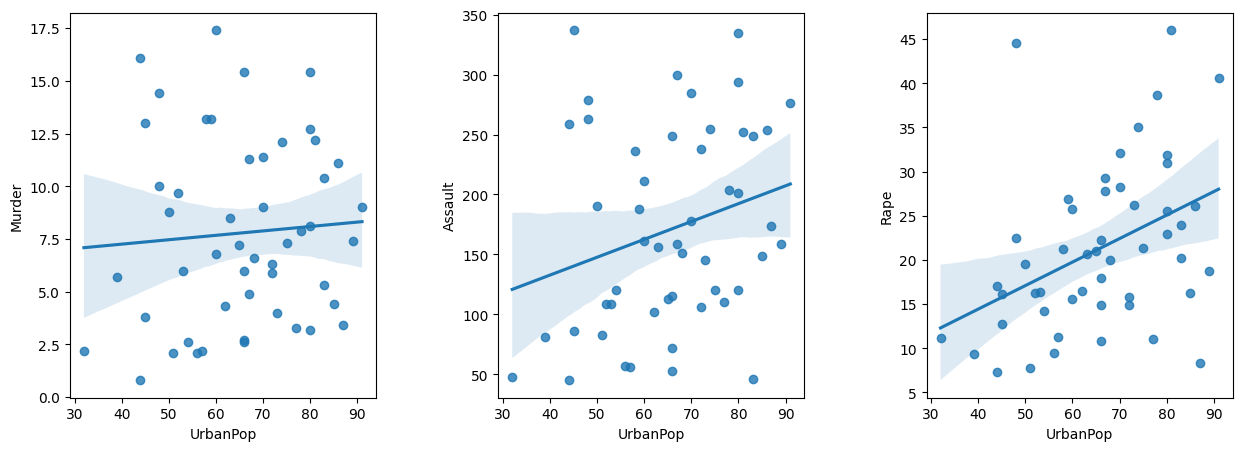

In [3]:
# create a figure with a 3x1 grid of subplots using matplotlib
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# creating scatterplots to populate each segment of the matplotlib grid 
sns.regplot(data=df, x="UrbanPop", y="Murder", ax=axs[0])
sns.regplot(data=df, x="UrbanPop", y="Assault", ax=axs[1])
sns.regplot(data=df, x="UrbanPop", y="Rape", ax=axs[2])

# add some space between the subplots
plt.subplots_adjust(wspace=0.4)

# display the plot
plt.show()

#### What we have learned from the charts above
- Crimes of all types increase with urban population
- Simple linear regression (the line of best fit) tells us that rapes are the most correlated with more population dense cities, closely followed by assaults. 
- Murders only gradually increase with urban population. 

<AxesSubplot: xlabel='UrbanPop', ylabel='Count'>

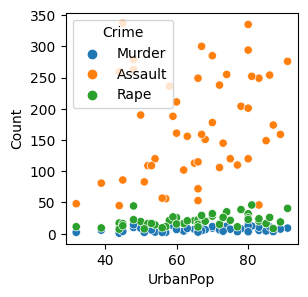

In [4]:
#create a new DataFrame in long format
df_long = pd.melt(df, id_vars=["UrbanPop"], value_vars=["Murder", "Assault", "Rape"], var_name="Crime", value_name="Count")

# create a scatterplot with the melted DataFrame and custom size
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=df_long, x="UrbanPop", y="Count", hue="Crime", ax=ax)


#### What we have learned from the chart above
 - Assaults are the most common arrest in the database by a long way. Rapes are the next most common (particularly common in areas of high urban population) and murders are the least common.
 - We definitely need to scale our data before moving to cluster analysis because assaults are on a much larger scale than rape and murder and so could risk dominating our cluster analysis 

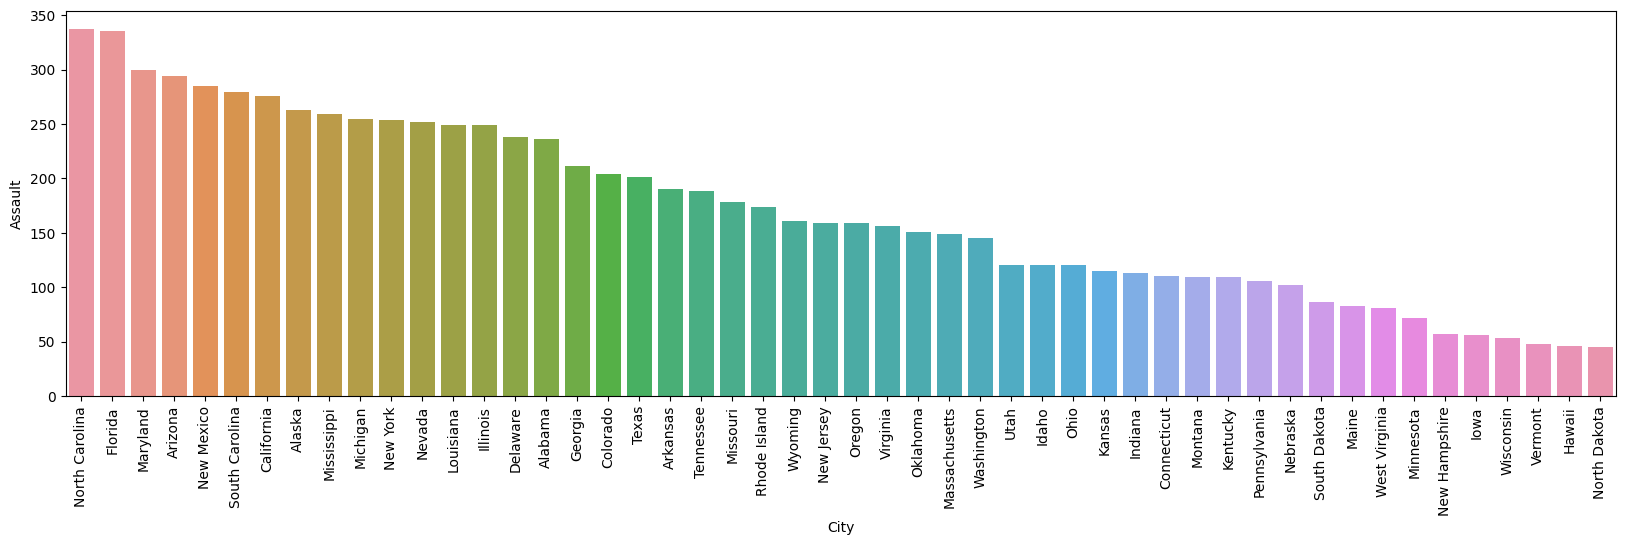

In [5]:
#Bar chart to show which states have the highest number of crimes (in absolute terms) proxied by assaults
df = df.sort_values(by="Assault", ascending=False)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=df, x="City", y="Assault")
plt.xticks(rotation=90)
plt.show()

#### What we have learned from the barchart above?
- There is a large variation in assaults between states. The state with the highest level of assaults has roughly six times the amount of arrests than the state with the lowest level of assaults. 
- North Carolina, Florida and Maryland have the highest number of assaults
- Assaults are highly correlated with other crimes and therefor indicative of wider crime levels
- North Dakota, Hawaii and Vermont have the lowest number of assault arrests, although this might be due to a lower population. Hence in the next chart, we investigate crime rates. 

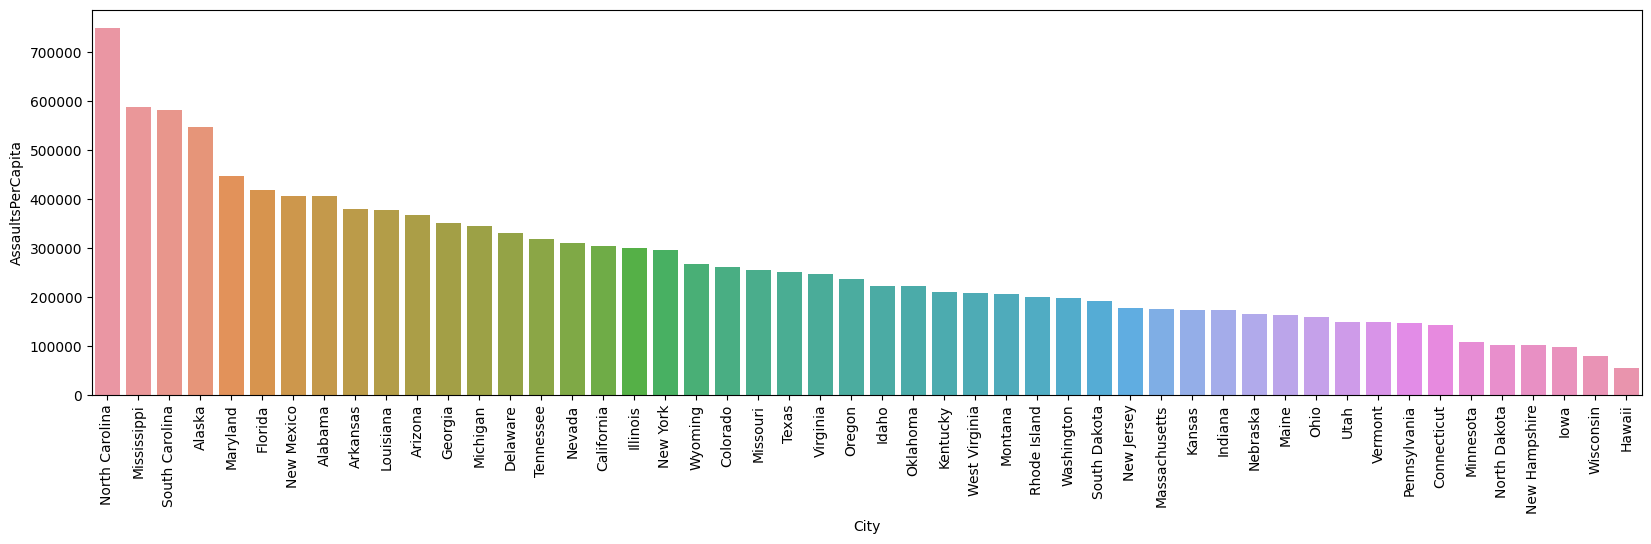

In [6]:
#Bar chart to show which states have the highest crime rate (proxied by assaults per capita in urban centres)
df["AssaultsPerCapita"] = df["Assault"] / df["UrbanPop"] * 100000
df = df.sort_values(by="AssaultsPerCapita", ascending=False)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=df, x="City", y="AssaultsPerCapita")
plt.xticks(rotation=90)
plt.show()

#### What have we leared from the chart above?
- Crime rate changes the order of crime prevelance, but not by a lot
- There is a similar variation in crime recorded between states when we add urban population as a denominator. 
- North Caroline still comes out on top for the city with the highest urban crime rate, however this time its followed by Mississippi and South Carolina. Hawaii still ranks within the bottom two. 


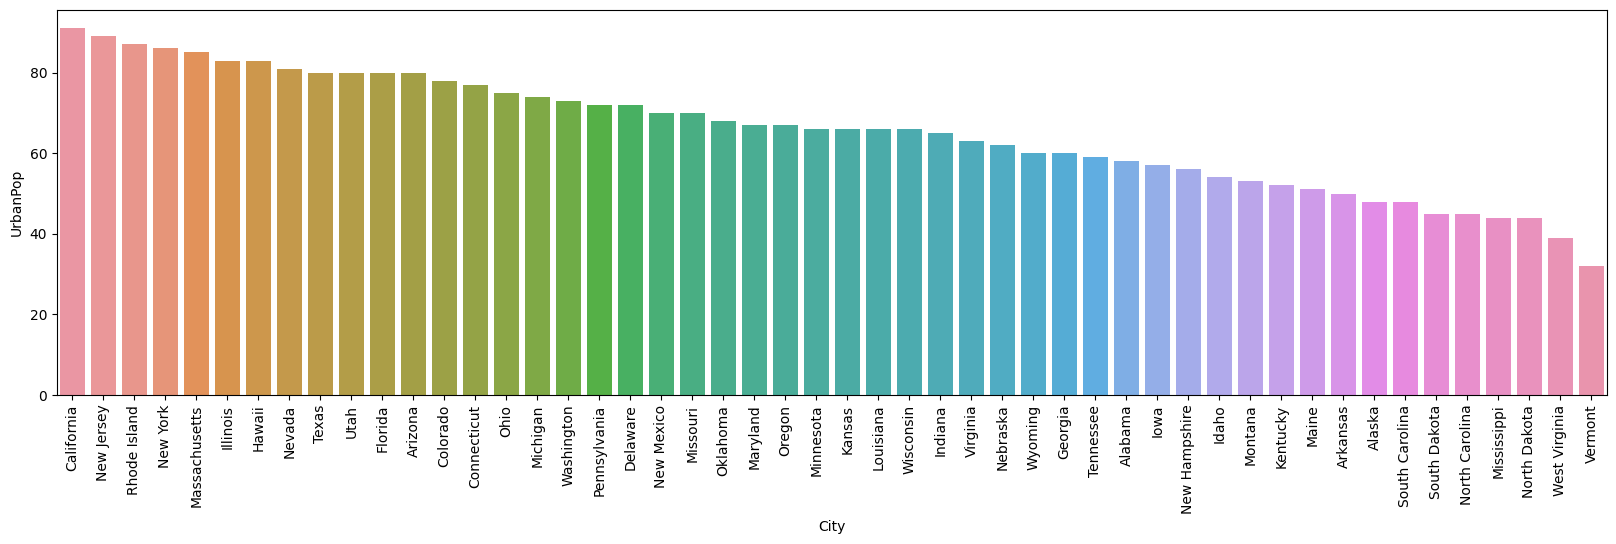

In [20]:
#Bar chart to show which states have the highest uban population
df = df.sort_values(by="UrbanPop", ascending=False)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=df, x="City", y="UrbanPop")
plt.xticks(rotation=90)
plt.show()

### Correlation Analysis

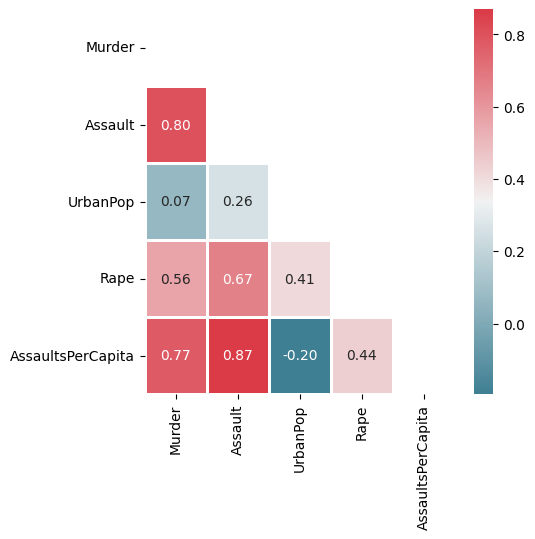

In [7]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(5, 5))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)

#### What have we learned from the cluster chart above?
- That the most correlated variables are assault and murder with a correlation coefficient of 0.8. Therefor, we could have chosen to exclude one of these variables if further analysis required a more reductionist approach. 
- Reinforcing our visual analysis from some of the scatter graphs above, there is a very low correlation between murders and urban population. Murders are almost as likely to happen in a low density state compared with a high density state. 
- Due to the small number of variables in this dataset, we will not be performing any reductionist techniques such as a PCA. 

### Hierarchical clustering

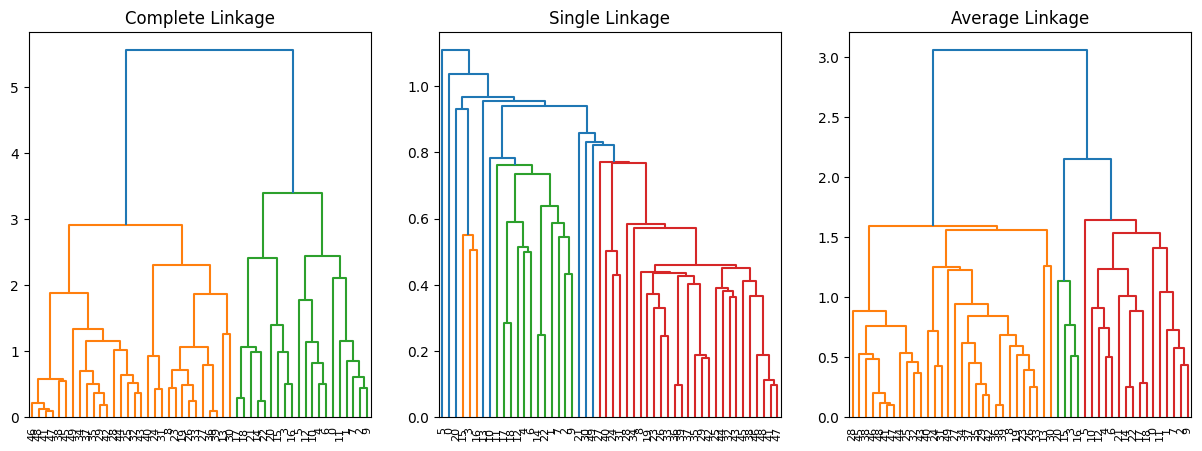

In [8]:
#Scaling the data ahead of cluster analysis
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["Murder", "Assault", "Rape"]])
df_scaled = pd.DataFrame(df_scaled, columns=["Murder", "Assault", "Rape"])

#Hierarhical cluster analysis
X = df_scaled[["Murder", "Assault", "Rape"]]
linkage_methods = ["complete", "single", "average"]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Loops over the linkage methods and plot a dendrogram for each one
for i, method in enumerate(linkage_methods):
    Z = linkage(X, method=method)
    dn = dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"{method.capitalize()} Linkage")

# display the plot
plt.show()

#### What have we learned from the dendrograms above?
- Above of dendrograms representing differentiated characteristics between crime types. 

- From the dendrograms above, the complete linkage and average linkake lead to the most balanced dispersion of clusters which are well defined. However, knowing the wider context of the types of crime, we will select the average linkage method to take us forward as this best identified that there are 3 rather than 2 main clusters of crimes. 

- We will be constraining our models to identify 3 crime types in the K-Means cluster plot later on

- Before we do however, we will perform an average linkage cluster below, adding in cities to see if this helps or crowd the picture. 

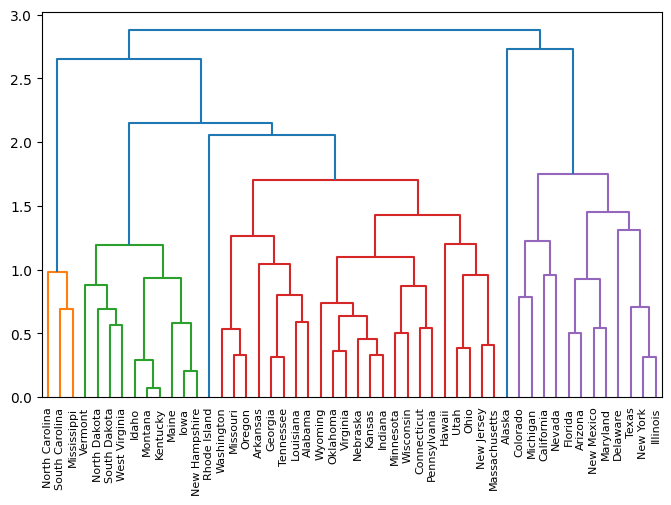

In [21]:
#Selects the integer variables to cluster and scale them
X = df[["Assault", "Rape", "UrbanPop"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Adds back in the categoric variable (city)
cities = df["City"]

#Performs hierarchical clustering with average linkage and plots the results
Z = linkage(X, method="average")
fig, ax = plt.subplots(figsize=(8, 5))
dn = dendrogram(Z, labels=cities.values, leaf_rotation=90, leaf_font_size=8)
plt.show()

#### What have we learned from the dendrogram above?

- First things first, why have we chosen the parameters we chose for this dendrogram?
    - average linkage performed the best in the test clustering above so we have leverage that technique here
    - we have removed murder as it was strongly correlated with assaults (as we learned from the correlation matrix)
    - we added in urban population to the 2 crime rates and then added city names
    
- Learnings from the data include 
    - The cluster on the left represents low density, high crime rate states in the south-east of the US
    - The next cluster from the left represents middle-america which has average crime rates and low population density
    - The next cluster is Rhode Island which is high density with a low crime rate - and quite dissimilar (as decided by the model) from other states
    - The next cluster represent middle-america which are lower in population density with above average crime rates with the exception of the Hawaaii - Massachustess cluster which has high population density and low crime rate
    - Lastly, the southern states are split into high density, high crime and low density low crime 

### K-Means Clustering

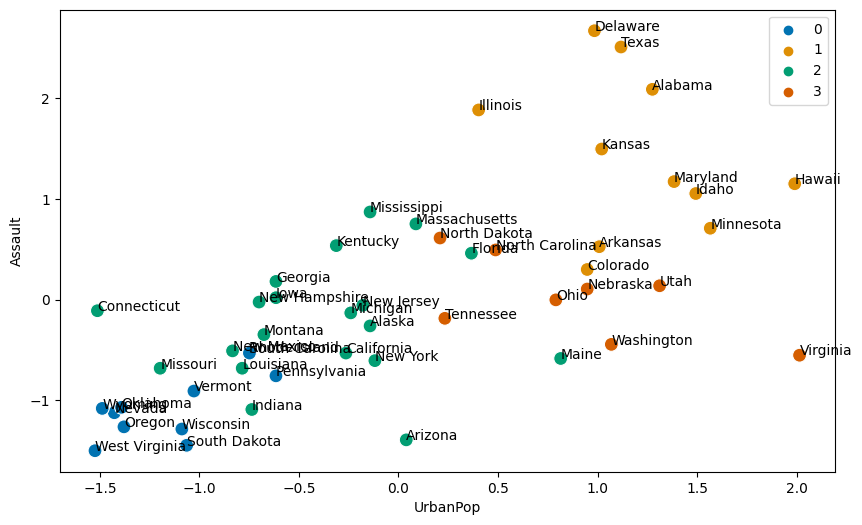

In [23]:
# perform K-means clustering with K=4
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_

# add the city names as labels
cities = df["City"]

# plot the resulting clusters
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, legend='full', palette='colorblind', s=100)
for i, city in enumerate(cities):
    ax.annotate(city, (X[i,0], X[i,1]))
plt.xlabel("UrbanPop")
plt.ylabel("Assault")
plt.show()

#### What have we learned from the dendrogram above?

- Based on the previous dendrogram, 4 clusters have been identified and used as a constraint in the K-Means cluster analysis
- Alaska and Hawaii fell outside of characteristics of the 4 identified clusters as they were low population and high crime (Alaska) or high population and low crime (Hawaii) which tended to fall outside of the trend that crime levels increase with urban population. 
- Ignoring Hawaii, the ambber cluster represents southern states where assaults are high and so is the population
- The red cluster represents central america with a moderately high urban population but a lower assault rate
- The green cluster represents states from a mix of geographies with an average urban population and number of assaults. 
- Then the blue cluster represent northern states